# Lesson 21

[Course Repo](https://github.com/fastai/course22p2)



## Weights and Balances (WandB) demo

Jono: Demo of WandB.  (notebook 21_cifar10_and_wandb.ipynb) 

Main points:

- Uses CFAR10 instead of fashion mnist.  The tools still work. 
- Weights and Biases (WandB) mointoring:
    -  [WandB](https://wandb.ai/site) for monitoring and tracking of model performance. 
    -  Call logging functions in your code to log metrics, hyperparameters, and other data to the WandB server, and then you can view and compare these results in the WandB dashboard.
    -  You can also use WandB to log models, code and more.
- Jono implements a WandB callback in a few lines to implment this!
- Jeremy says he doesn't use this (intentionally) because he worries about just doing wide sweeps of hyperparameters.  He prefers to do a more focused search.

## Image quality metrics

- We need a metric to evaluate the quality of the generated images, to compare different samplers or models. 

- **Frechet Inception Distance (FID)**:  
  - Demonstration available in `18_fid.ipynb` at the course repo. 
  - FID is a commonly used metric for evaluating image-generating models.  
  - It measures how similar the generated images are to real ones.  
  - Specifically, it compares the statistical properties of the 'typical' final layer activations from a pretrained neural network for both sets of images.  


In [1]:

import pickle,gzip,math,os,time,shutil,torch,random
import fastcore.all as fc,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager
from scipy import linalg

from fastcore.foundation import L
import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torch.optim import lr_scheduler
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder

from minai.datasets import *
from minai.conv import *
from minai.learner import *
from minai.activations import *
from minai.init import *
from minai.sgd import *
from minai.resnet import *
from minai.augment import *
from minai.accel import *

In [2]:
from fastcore.test import test_close
from torch import distributions

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray_r'

import logging
logging.disable(logging.WARNING)

set_seed(42)
if fc.defaults.cpus>8: fc.defaults.cpus=8

### Use existing classifier with classifier head removed

* Using a model I trained previously for classification of fashion mnist. 
* Remove the classifier head and use the final layer activations as the features for the FID calculation.

In [3]:
xl,yl = 'image','label'
name = "fashion_mnist"
# changed from 512 to 256
bs = 256

@inplace
def transformi(b): b[xl] = [F.pad(TF.to_tensor(o), (2,2,2,2))*2-1 for o in b[xl]]

dsd = load_dataset(name)
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=fc.defaults.cpus)

b = xb,yb = next(iter(dls.train))

cbs = [DeviceCB(), MixedPrecision()]
# I dont have a data_aug2 so hopefully this one will work
model = torch.load('models/data_aug.pkl')
learn = Learner(model, dls, F.cross_entropy, cbs=cbs, opt_func=None)


/tmp/ipykernel_37529/4001158253.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('models/data_aug.pkl')


In [4]:
model

Sequential(
  (0): ResBlock(
    (convs): Sequential(
      (0): Sequential(
        (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): GeneralRelu()
      )
      (1): Sequential(
        (0): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (idconv): Sequential(
      (0): Conv2d(1, 16, kernel_size=(1, 1), stride=(1, 1))
    )
    (act): GeneralRelu()
  )
  (1): ResBlock(
    (convs): Sequential(
      (0): Sequential(
        (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): GeneralRelu()
      )
      (1): Sequential(
        (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): 

We want the output without the classifier head.  

In [5]:
del(learn.model[8])
del(learn.model[7])

Could also use callbacks to do this.

In [6]:
feats,y = learn.capture_preds()
feats = feats.float()
feats.shape,y

/home/ron/datadev/pdl/minai/accel.py:29: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  def before_fit(self, learn): self.scaler = torch.cuda.amp.GradScaler()


(torch.Size([10000, 512]), tensor([9, 2, 1,  ..., 8, 1, 5]))

### Flechet Inception Distance (FID)

- Uses means and covariance matrix of the global pooling layer (accross the samples/training data) of the classification model
- These are compared for two batches of images (generated and real) to get a distance metric.
- Idea is that the pooling layer has activations for various feature in the images. If those features are correlated (e.g. ears and eyes) then the means and covariance matrix will be correlated.
 
$$
d_{F}(\mathcal N(\mu, \Sigma), \mathcal N(\mu', \Sigma'))^2 = \lVert \mu - \mu' \rVert^2_2 + \operatorname{tr}\left(\Sigma + \Sigma' -2\left(\Sigma \Sigma'  \right)^\frac{1}{2} \right)
$$

Note the need of the matrix square root. The video spends a few minutes discussing how to compute this with a generalizatoin of newton's method.

* Called Inception because the original paper used the Inception model.
* Primary caveat is that you have to be careful comparing FID scores with different sized data sets. Not a universal metric.
* FID is a good metric for comparing different models on the same data set.


Now we need our image generator again.

In [7]:
betamin,betamax,n_steps = 0.0001,0.01,1000
beta = torch.linspace(betamin, betamax, n_steps)
alpha = 1.-beta
alphabar = alpha.cumprod(dim=0)
sigma = beta.sqrt()

clean_mem()

def noisify(x0, ᾱ):
    device = x0.device
    n = len(x0)
    t = torch.randint(0, n_steps, (n,), dtype=torch.long)
    ε = torch.randn(x0.shape, device=device)
    ᾱ_t = ᾱ[t].reshape(-1, 1, 1, 1).to(device)
    xt = ᾱ_t.sqrt()*x0 + (1-ᾱ_t).sqrt()*ε
    return (xt, t.to(device)), ε

def collate_ddpm(b): return noisify(default_collate(b)[xl], alphabar)
def dl_ddpm(ds): return DataLoader(ds, batch_size=bs, collate_fn=collate_ddpm, num_workers=4)

dls2 = DataLoaders(dl_ddpm(tds['train']), dl_ddpm(tds['test']))


from diffusers import UNet2DModel

class UNet(UNet2DModel):
    def forward(self, x): return super().forward(*x).sample


smodel = torch.load('models/fashion_ddpmDec15.pkl').cuda()

/tmp/ipykernel_37529/2307509700.py:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  smodel = torch.load('models/fashion_ddpmDec15.pkl').cuda()


In [8]:
# @torch.no_grad()
# def sample(model, sz, alpha, alphabar, sigma, n_steps):
#     device = next(model.parameters()).device
#     x_t = torch.randn(sz, device=device)
#     preds = []
#     for t in reversed(range(n_steps)):
#         t_batch = torch.full((x_t.shape[0],), t, device=device, dtype=torch.long)
#         z = (torch.randn(x_t.shape) if t > 0 else torch.zeros(x_t.shape)).to(device)
#         ᾱ_t1 = alphabar[t-1]  if t > 0 else torch.tensor(1)
#         b̄_t = 1 - alphabar[t]
#         b̄_t1 = 1 - ᾱ_t1
#         x_0_hat = ((x_t - b̄_t.sqrt() * model((x_t, t_batch)))/alphabar[t].sqrt())
#         x_t = x_0_hat * ᾱ_t1.sqrt()*(1-alpha[t])/b̄_t + x_t * alpha[t].sqrt()*b̄_t1/b̄_t + sigma[t]*z
#         preds.append(x_0_hat.cpu())
#     return preds

# Alternative version. Algorithm 2 from the paper
@torch.no_grad()
def sample(model, sz, alpha, alphabar, sigma, n_steps):
    device = next(model.parameters()).device
    x_t = torch.randn(sz, device=device)  # x_T 
    preds = []
    for t in reversed(range(n_steps)):
        t_batch = torch.full((x_t.shape[0],), t, device=device, dtype=torch.long) # make it look like a batch
        z = (torch.randn(x_t.shape) if t > 0 else torch.zeros(x_t.shape)).to(device)
        b̄_t = 1 - alphabar[t]
        x_t = ((x_t -(1- alpha[t])/ b̄_t.sqrt() * model((x_t, t_batch)))/alpha[t].sqrt()) + sigma[t]*z
        preds.append(x_t.cpu())
    return preds

Note this takes much longer for my machine then in teh video. Video did this in 34 seconds. For me it was 2 minutes.

In [9]:
%%time
samples = sample(smodel, (256, 1, 32, 32), alpha, alphabar, sigma, n_steps)

CPU times: user 2min 6s, sys: 2.48 s, total: 2min 9s
Wall time: 2min 9s


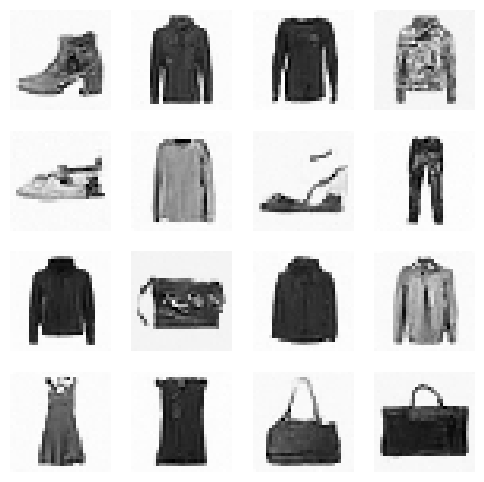

In [10]:
s = samples[-1]*2  
show_images(s[:16], imsize=1.5)

### Image Eval class

- To make this easier to use, we can create a class to handle the evaluation of the images.

- In addition to FID, the video quickly introduces another metric called KID (Kernal Inception Distance)
    - Uses the features directly not the means accross the set. 
    - "The math doesnt matter" 
    - Measure of simularity between the distribtuions of the features.   
    - Has low bias but high variance.



In [11]:

def _calc_stats(feats):
    feats = feats.squeeze()
    return feats.mean(0),feats.T.cov()

def _calc_fid(m1,c1,m2,c2):
    csr = tensor(linalg.sqrtm(c1@c2, 256).real)
    return (((m1-m2)**2).sum() + c1.trace() + c2.trace() - 2*csr.trace()).item()



def _squared_mmd(x, y):
    def k(a,b): return (a@b.transpose(-2,-1)/a.shape[-1]+1)**3
    m,n = x.shape[-2],y.shape[-2]
    kxx,kyy,kxy = k(x,x), k(y,y), k(x,y)
    kxx_sum = kxx.sum([-1,-2])-kxx.diagonal(0,-1,-2).sum(-1)
    kyy_sum = kyy.sum([-1,-2])-kyy.diagonal(0,-1,-2).sum(-1)
    kxy_sum = kxy.sum([-1,-2])
    return kxx_sum/m/(m-1) + kyy_sum/n/(n-1) - kxy_sum*2/m/n


def _calc_kid(x, y, maxs=50):
    xs,ys = x.shape[0],y.shape[0]
    n = max(math.ceil(min(xs/maxs, ys/maxs)), 4)
    mmd = 0.
    for i in range(n):
        cur_x = x[round(i*xs/n) : round((i+1)*xs/n)]
        cur_y = y[round(i*ys/n) : round((i+1)*ys/n)]
        mmd += _squared_mmd(cur_x, cur_y)
    return (mmd/n).item()

In [12]:
class ImageEval:
    def __init__(self, model, dls, cbs=None):
        self.learn = TrainLearner(model, dls, loss_func=fc.noop, cbs=cbs, opt_func=None)
        self.feats = self.learn.capture_preds()[0].float().cpu().squeeze()
        self.stats = _calc_stats(self.feats)

    def get_feats(self, samp):
        self.learn.dls = DataLoaders([],[(samp, tensor([0]))])
        return self.learn.capture_preds()[0].float().cpu().squeeze()

    def fid(self, samp): return _calc_fid(*self.stats, *_calc_stats(self.get_feats(samp)))
    def kid(self, samp): return _calc_kid(self.feats, self.get_feats(samp))

In [13]:
ie = ImageEval(model, learn.dls, cbs = [DeviceCB()])
ie.fid(s)

8.92059326171875

Note Jeremy's was only 8, but he did train for 25 epochs vs my 10 epochs, and has more images in his batch. Note that setting betamax to 0.01 instead of 0.02 makes a huge difference.  

In [42]:
s.min(),s.max()

(tensor(-1.16), tensor(1.45))

In [14]:
ie.fid(xb)

9.7236328125

## Fixing the scaling bug 1:00

- Jeremy noticed that back in the DDPM_v2 notebook, the images were scaled from 0 to 1 instad of -1 to 1.   He fixes this:
```
@inplace
def transformi(b): b[xl] = [F.pad(TF.to_tensor(o), (2,2,2,2))*2-1 for o in b[xl]]
```

- This makes everything worse, so he spent two days trying to find the other bug that must be responsble and was being offset by this bug.

- In the end he finds no relavent bug and asks: why is it a bug to scale from 0 to 1? Just because everyone else does it?  He tried it ny just subtracting 0.5 which keeps the range the same (smaller then normal). This leads to DDBM_v3. This is an improvement to the model.  This is the model I am using already above. 
 

## Skip sampling

* I am skipping this part as it is a bit ad hoc. 

* Moving on to DDIM

## DDIM (Denoising Diffusion Implicit Model) 1:20  

Notebook: 20_DDIM.ipynb

Reimport things so we can start here

In [1]:
clean_mem()

NameError: name 'clean_mem' is not defined

In [2]:
import pickle,gzip,math,os,time,shutil,torch,random,logging
import fastcore.all as fc,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
from collections.abc import Mapping
from pathlib import Path
from functools import partial

from fastcore.foundation import L
import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torch.optim import lr_scheduler

from minai.datasets import *
from minai.conv import *
from minai.learner import *
from minai.activations import *
from minai.init import *
from minai.sgd import *
from minai.resnet import *
from minai.augment import *
from minai.accel import *
from minai.fid import *


from fastprogress.fastprogress import progress_bar

In [3]:
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder

mpl.rcParams['image.cmap'] = 'gray_r'
logging.disable(logging.WARNING)

In [4]:
xl,yl = 'image','label'
name = "fashion_mnist"
dsd = load_dataset(name)

In [5]:
from diffusers import UNet2DModel, DDIMPipeline, DDPMPipeline, DDIMScheduler, DDPMScheduler

## Diffusers DDPM Scheduler

This uses the diffusers library scheduler. 

It uses the full output of the model, so we dont need to call sample , etc: 

In [6]:
class UNet(UNet2DModel): pass

In [7]:

model = torch.load('models/fashion_ddpmDec15.pkl').cuda()

/tmp/ipykernel_983/2524294428.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('models/fashion_ddpmDec15.pkl').cuda()


In [8]:
sched = DDPMScheduler(beta_end=0.01)

In [9]:
sz = (256,1,32,32) # notebook used 2048 !  !

In [10]:
%%time
x_t = torch.randn(sz).cuda()
preds = []

for t in progress_bar(sched.timesteps):
    with torch.no_grad(): noise = model(x_t, t).sample
    x_t = sched.step(noise, t, x_t).prev_sample
    preds.append(x_t.float().cpu())

CPU times: user 2min 12s, sys: 2.8 s, total: 2min 15s
Wall time: 2min 15s


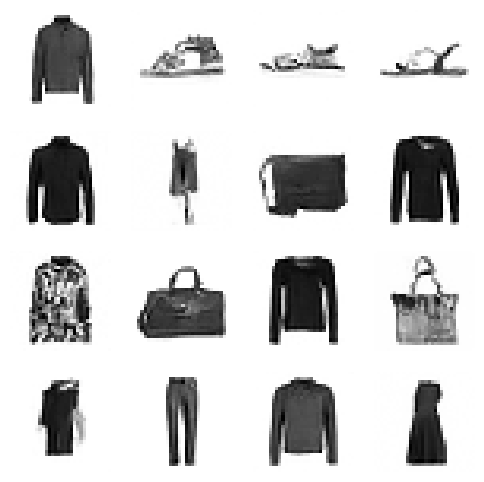

In [11]:
s = preds[-1].clamp(-0.5,0.5)*2
show_images(s[:16], imsize=1.5)

Set up classifier for image eval

In [12]:
cmodel = torch.load('models/data_aug.pkl')
del(cmodel[8])
del(cmodel[7])

@inplace
def transformi(b): b[xl] = [F.pad(TF.to_tensor(o), (2,2,2,2))*2-1 for o in b[xl]]

bs = 256 # Changed from 2048 to 256
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=fc.defaults.cpus)

dt = dls.train
xb,yb = next(iter(dt))

ie = ImageEval(cmodel, dls, cbs=[DeviceCB()])

/tmp/ipykernel_983/1778349126.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cmodel = torch.load('models/data_aug.pkl')


This will be for comparing to the DDIM model.  Note that my results are different due to a couple of things:

1- I trained my denoising model for 10 not 25 epochs

2- My image classifier model may be different. 

3- Batch size is much less for me. (256 vs 2048)

But this is ok, we are going to use the same settings when we get to the DDIM model..

Also i note that 256 images took 2 min 7 seconds

In [13]:
ie.fid(s),ie.kid(s)

(11.283172607421875, 0.030962148681282997)

Note that this is about the same as our  linear schedular.  (Note that previously it was better, but then I noted that betamax was 0.01 instead of 0.02)

In [14]:
ie.fid(xb), ie.kid(xb)

(9.097381591796875, -0.00871006678789854)

### Diffusers built in DDIM 

In [15]:
sched = DDIMScheduler(beta_end=0.01)
sched.set_timesteps(100) # skip 10

def diff_sample(model, sz, sched, **kwargs):
    x_t = torch.randn(sz).cuda()
    preds = []
    for t in progress_bar(sched.timesteps):
        with torch.no_grad(): noise = model(x_t, t).sample
        x_t = sched.step(noise, t, x_t, **kwargs).prev_sample
        preds.append(x_t.float().cpu())
    return preds


In [16]:
%%time
preds = diff_sample(model, sz, sched, eta=1.) # WHY eta=1.0? This just same as DDPM right?
s = (preds[-1]*2).clamp(-1,1)

CPU times: user 13.5 s, sys: 309 ms, total: 13.8 s
Wall time: 13.8 s


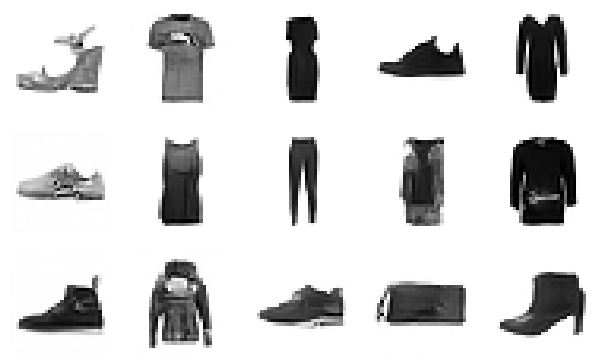

In [17]:
show_images(s[:15], imsize=1.5)

In [18]:
ie.fid(s),ie.kid(s)

(12.235565185546875, 0.06591805070638657)

Much faster (12 s) and the fid is only a bit worse

### Implementing DDIM

[paper](https://arxiv.org/abs/2010.02502)

Here we go back to **our** linear schedular.

In [19]:
from types import SimpleNamespace
n_steps=1000

def linear_sched(betamin=0.0001,betamax=0.02,n_steps=1000):
    beta = torch.linspace(betamin, betamax, n_steps)
    return SimpleNamespace(a=1.-beta, abar=(1.-beta).cumprod(dim=0), sig=beta.sqrt())

sc = linear_sched(betamax=0.01, n_steps=n_steps)
abar = sc.abar



* In DDPM, they derived (from the forward process) the conditional probability of the next image given the previous image and given the initial images:

$$
q(\mathbf{x}_{t-1} | \mathbf{x}_t, \mathbf{x}_0)
$$

* This was used to derive the sampling (reverse) process loss function

* In DDIM, they generalize this reverse step into a more general (non-Markovian) form that still  results in the same loss function and training.  The forward process is different step by step (and not used), but this step is designed so that the overall $q(x_t,x_0)$ is the same.  The generalization allows for more flexible added noise in the reverse process, equation 6 in the paper. 

* To use this model, you simply need to compute the noise with your model as usual, but apply a different denoising (sampling) step:

![sample](images/DDIMSampling.png)


* $\sigma$ is defined as:

![sigma](images/DDIMSigma.png)



* Here $\eta$ is a variable that ranges from 0 (pure DDIM) to 1 (DDPM). $\tau_i$ is the subset of timesteps.

* Why does this work better for skipping steps?  I believe it is due to the deterministic nature of the DDIM model, but this is only in effect when $\eta$ is 0.  Jerermy uses $\eta = 1$ which I do not understand. **Anyone?**

In [20]:

def ddim_step(x_t, t, noise, abar_t, abar_t1, bbar_t, bbar_t1, eta):
    vari = ((bbar_t1/bbar_t) * (1-abar_t/abar_t1))
    sig = vari.sqrt()*eta
    x_0_hat = ((x_t-bbar_t.sqrt()*noise) / abar_t.sqrt())
    x_t = abar_t1.sqrt()*x_0_hat + (bbar_t1-sig**2).sqrt()*noise
    if t>0: x_t += sig * torch.randn(x_t.shape).to(x_t)
    return x_t

More general sampling function

In [21]:
@torch.no_grad()
def sample(f, model, sz, n_steps, skips=1, eta=1.):
    tsteps = list(reversed(range(0, n_steps, skips)))
    x_t = torch.randn(sz).to(model.device)
    preds = []
    for i,t in enumerate(progress_bar(tsteps)):
        abar_t1 = abar[tsteps[i+1]] if t > 0 else torch.tensor(1)
        noise = model(x_t,t).sample
        x_t = f(x_t, t, noise, abar[t], abar_t1, 1-abar[t], 1-abar_t1, eta)
        preds.append(x_t.float().cpu())
    return preds

Test it, skipping 10 .. MUCH faster.  12 seconds vs 2 minutes.

In [22]:
%%time
samples = sample(ddim_step, model, sz, 1000, 10)

CPU times: user 13.6 s, sys: 260 ms, total: 13.9 s
Wall time: 13.9 s


In [23]:
s = (samples[-1]*2)#.clamp(-1,1)
ie.fid(s),ie.kid(s)

(11.81622314453125, 0.03799160197377205)

A bit worse then the huggingface ddim version. But then again this fluctuates a bit and we are using the simpler linear schedular. But since $\eta$ is 1, I would have expected this to be the same or worse (due to the skip) then the DDPM we did before.

NOTE ADDED:  The fluctuations in the FID score here are quite big, about 5 points or so. This is due to the smaller batch sizes i am using here (256) vs 2048 in the lesson videos.


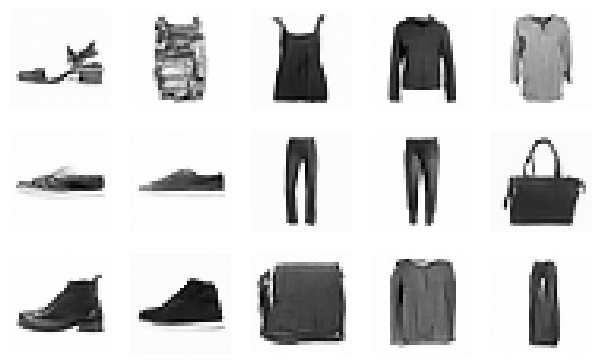

In [24]:
s = (samples[-1]*2)#.clamp(-1,1)
show_images(s[:15], imsize=1.5)

But wait, if eta is 1 thats the same as DDPM isnt it?   Lets try eta = 0.0

In [25]:
%%time
samples = sample(ddim_step, model, sz, 1000, 10, eta=0)

CPU times: user 13.5 s, sys: 267 ms, total: 13.8 s
Wall time: 13.8 s


In [26]:
s = (samples[-1]*2)#.clamp(-1,1)
ie.fid(s),ie.kid(s)

(14.42327880859375, 0.041572969406843185)

Seems a bit worse ...  ?